<a href="https://colab.research.google.com/github/dp457/LangChainLLM/blob/main/Building_a_RAG_App_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

One of the most powerful applications enabled by LLMs is sophisticated question-answering (Q&A) chatbots. These are applications that can answer questions about specific source information. These applications use a technique known as Retrieval Augmented Generation.

This tutorial will show how to build a simple Q&A application over a text data source. Along the way we’ll go over a typical Q&A architecture and highlight additional resources for more advanced Q&A techniques.

# Overview

Typical RAG has two components

1. **Indexing:** pipeline for ingesting data from the source and indexing it. This is done offline.

2. **Retrieval and generation:** RAG chain that takes in the user query at run time and retrieves relevant data from index and passes on to that model.

## Indexing:

1. **Load:** Loading the data using `Document Loaders`.
2. **Splitters:** Break the large documents in small chunks. Useful for both indexing the data and passing into the model, large chunks are harder to search over and will not fit in the context window.
3. **Store:** To store and index the splits, so that they can be searched over later. Done using `VectorStore` and `EmbeddingModel`.
4. **Retrieve:** Given a user input, relevant splits are retrieved from storage using a `Retriever`.
5. **Generate**: LLM produces an answer using a prompt that includes both the question with the retrieved data.

Once the data is indexed, LangGraph orchestration framework used to implement the retrieval and generation steps.


In [1]:
!pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 15.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests

In [2]:
# 1) Install Ollama in the Colab VM
!curl -fsSL https://ollama.com/install.sh | sh

>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [4]:
# 2) Start the server in the background
import subprocess, time
server = subprocess.Popen(["ollama", "serve"])
time.sleep(5)  # give it a moment to boot

In [5]:
# 3) Pull a smallish model
!ollama pull llama3.1

In [6]:
!pip install langchain-ollama

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [langchain-ollama]


In [7]:
from langchain_ollama import ChatOllama
llm = ChatOllama(base_url="http://127.0.0.1:11434", model="llama3.1", temperature=0.3)

from langchain.chat_models import init_chat_model

model = init_chat_model(
    "llama3.1",                # any model you've pulled in Ollama
    model_provider="ollama",
    base_url="http://127.0.0.1:11434",
    temperature=0.3,
)

In [10]:
import os
from langchain_ollama import OllamaEmbeddings

# No need for API key with Ollama if running locally
# Make sure Ollama is installed and running: https://ollama.com/download

embeddings = OllamaEmbeddings(model="nomic-embed-text")
# Example usage
text = "This is a test sentence."


In [11]:
!ollama pull nomic-embed-text

Sample visualization of the embeddings

In [12]:
vector = embeddings.embed_query(text)
print(len(vector), vector[:10])  # length + first 10 dims

768 [0.05667541, 0.01778301, -0.15581644, -0.017666122, 0.070547655, 0.016326046, 0.029868228, -0.028160512, 0.028266368, -0.01864758]


In [13]:
!pip install -qU langchain-core

In [14]:
from langchain_core.vectorstores import InMemoryVectorStore
vector_store = InMemoryVectorStore(embeddings)

# Preview

Here an app will be built that answers questions about a website's content. We will use this famous [blog](https://lilianweng.github.io/posts/2023-06-23-agent/) and hence questions will be asked about the contents of the post.

In the following codes small indexing pipeline and RAG chain is formulated.

In [16]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

In [17]:
# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

In [18]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

In [21]:
!export LANGCHAIN_API_KEY="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"

In [22]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull("rlm/rag-prompt")

/usr/local/lib/python3.12/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [23]:
# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [24]:
# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

In [25]:
def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [26]:
# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [27]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])

Task decomposition involves breaking down complex tasks into smaller, manageable steps. This can be achieved through various methods, including simple prompting with LLMs, task-specific instructions, or human inputs. The goal of task decomposition is to transform big tasks into multiple manageable tasks and shed light on the model's thinking process.


# Detailed Walkthroughs

## 1. Indexing

### Loading Documents

The blog post contents need to be load first, using Document Loaders. It consists of objects that load in data from a source and returns a list of Document objects.

`WebBaseLoader` is used, which uses `urlib` to load the HTML from the web URLs, and `BeautifulSoup` used for parsing it. In this case only HTML tags with class “post-content”, “post-title”, or “post-header” are relevant, hence others are removed.

In [28]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43047


In [29]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


## Splitting Documents

The loaded document has over 42k parameters, hence it cannot be fit within the context window of the models. Even for those models that could fit the full characters in their context window, models can struggle to find information in very long inputs.

Hence, in order to be handled well, the `Document` can be split into chunks of embeddings or vector storage. Hence, it will help retrieve only the relevant parts of the blog post during run-time/

`RecursiveCharacterSplitter` is the recommended one.

In [30]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 63 sub-documents.


## Storing Documents

Now the extracted 63 text chunks need to be indexed so that the search can be conducted over them during runtime. The main approach is to embed the contents of each document split and the embeddings are inserted into a vector store. Vector search used to retrieve the relevant documents.

All the document splits are embedded and stored using the vector state and embedding models.

In [31]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['c5d10332-665e-402d-8f72-f75f1729bdee', 'dc187e8a-26f2-4a13-b250-bf322fbd3673', '96d8a3ac-445b-475c-81a5-00d06c97dcf5']


# Retrieval and Generation

A simple application is to be created  that takes a user question, searches for documents relevant to that question, passes the retrieved documents and initial question to a model, and returns an answer. The chat model for generation is selected at the start of the tutorial.

In [32]:
from langchain import hub

# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


/usr/local/lib/python3.12/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


LangGraph can be used to tie together the retrieval and generation steps within the single application. It has multiple benefits:

*   Application logic can be defined once, and automatically support multiple invocation modes, including streaming, async, and batched calls.
*   Supports streamlined deployments.
*   LangSmith will automatically trace the steps of our application together.
*   Key features can easily be added into the application which includes **persistence** and ** human-in-the-loop** approval.

For using the LangGraph three things need to be defined
1. State of the application.
2. Nodes of the application.
3. "Control flow" of the application.

For a simple RAG application, input question, retrieved context, and generated answer can be tracked.



In [33]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [34]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

1. The retrieval state runs a smilarity search using the input question.
2. Generation step formats the retrieved context and original question, into a prompt and a chat model.

## Control Flow

The application is compiled into a single `graph` object. Here the retrieval and generation steps are connected to a single sequence.

In [35]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

LangGraph also comes with built-in utilities for visualizing the control flow of the given application.

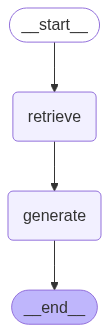

In [36]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

LangGraph supports multiple invocation modes, including sync, async, and streaming.

In [37]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(id='96d8a3ac-445b-475c-81a5-00d06c97dcf5', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1638}, page_content='Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth

Stream Steps:

In [38]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='96d8a3ac-445b-475c-81a5-00d06c97dcf5', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1638}, page_content='Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can

Stream Tokens:

In [39]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

Task| Decom|position| is| the| process| of| breaking| down| complex| tasks| into| smaller|,| manageable| steps|.| This| can| be| achieved| through| techniques| such| as| Chain| of| Thought| (|Co|T|)| or| Tree| of| Thoughts|,| which| involve| instruct|ing| a| model| to| "|think| step| by| step|"| and| generate| multiple| thought| steps|.| Task| decomposition| can| also| be| done| with| simple| prompting|,| task|-specific| instructions|,| or| human| inputs|.||

Returning sources
Note that by storing the retrieved context in the state of the graph, the sources for the model's generated answer in the "context" field of the state is recovered.

### Customizing the prompt



In [40]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)